# DAG Creation and Submission

Launch this tutorial in a Jupyter Notebook on Binder: 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/htcondor/htcondor-python-bindings-tutorials/master?urlpath=lab/tree/DAG-Creation-And-Submission.ipynb)

In this tutorial, we will learn how to use `htcondor.dags` to create and submit an HTCondor DAGMan workflow.
Our goal will be to create an image of the Mandelbrot set.
This is a perfect problem for high-throughput computing because each point in the image can be calculated completely independently of any other point, so we are free to divide the image creation up into patches, each created by a single HTCondor job.
DAGMan will enter the picture to coordinate stitching the image patches we create back into a single image.

## Making a Mandelbrot set image locally

We'll use `goatbrot` (https://github.com/beejjorgensen/goatbrot) to make the image.
`goatbrot` can be run from the command line, and takes a series of options to specify which part of the Mandelbrot set to draw, as well as the properties of the image itself.

`goatbrot` options:
- `-i 1000` The number of iterations.
- `-c 0,0` The center point of the image region.
- `-w 3` The width of the image region.
- `-s 1000,1000` The pixel dimensions of the image.
- `-o test.ppm` The name of the output file to generate.

We can run a shell command from Jupyter by prefixing it with a `!`:

In [1]:
! ./goatbrot -i 10 -c 0,0 -w 3 -s 500,500 -o test.ppm
! convert test.ppm test.png

Complex image:
            Center: 0 + 0i
             Width: 3
            Height: 3
        Upper Left: -1.5 + 1.5i
       Lower Right: 1.5 + -1.5i

Output image:
          Filename: test.ppm
     Width, Height: 500, 500
             Theme: beej
       Antialiased: no

Mandelbrot:
    Max Iterations: 10
        Continuous: no

Goatbrot:
    Multithreading: not supported in this build

Completed: 100.0%


Let's take a look at the test image. It won't be very good, because we didn't run for very many iterations.
We'll use HTCondor to produce a better image!

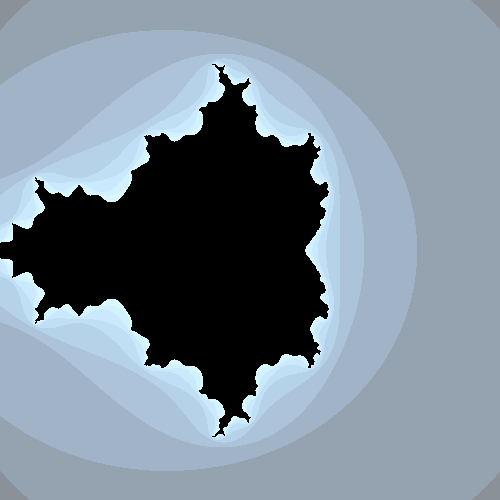

In [2]:
from IPython.display import Image

Image('test.png')

## What is the workflow?

We can parallelize this calculation by drawing rectangular sub-regions of the full region ("tiles") we want and stitching them together into a single image using `montage`.
Let's draw this out as a graph, showing how data (image patches) will flow through the system.
(Don't worry about this code, unless you want to know how to make dot diagrams in Python!)

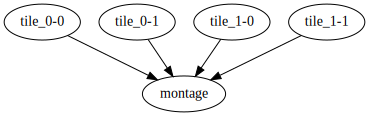

In [3]:
from graphviz import Digraph
import itertools

num_tiles_per_side = 2

dot = Digraph()

dot.node('montage')
for x, y in itertools.product(range(num_tiles_per_side), repeat = 2):
    n = f'tile_{x}-{y}'
    dot.node(n)
    dot.edge(n, 'montage')

dot

Since we can chop the image up however we'd like, we have as many tiles per side as we'd like (try changing `num_tiles_per_side` above).
The "shape" of the DAG is the same: there is a "layer" of `goatbrot` jobs that calculate tiles, which all feed into `montage`.
Now that we know the structure of the problem, we can start describing it to HTCondor.

## Describing `goatbrot` as an HTCondor job

We describe a job using a `Submit` object. 
It corresponds to the submit *file* used by the command line tools.
It mostly behaves like a standard Python dictionary, where the keys and values correspond to submit descriptors.

In [4]:
import htcondor

tile_description = htcondor.Submit(
    executable = 'goatbrot',  # the program we want to run
    arguments = '-i 10000 -c $(x),$(y) -w $(w) -s 500,500 -o tile_$(tile_x)-$(tile_y).ppm',  # the arguments to pass to the executable
    log = 'mandelbrot.log',  # the HTCondor job event log
    output = 'goatbrot.out.$(tile_x)_$(tile_y)',  # stdout from the job goes here
    error = 'goatbrot.err.$(tile_x)_$(tile_y)',   # stderr from the job goes here
    request_cpus = '1',        # resource requests; we don't need much per job for this problem
    request_memory = '128MB',
    request_disk = '1GB',
)

print(tile_description)

executable = goatbrot
arguments = -i 10000 -c $(x),$(y) -w $(w) -s 500,500 -o tile_$(tile_x)-$(tile_y).ppm
log = mandelbrot.log
output = goatbrot.out.$(tile_x)_$(tile_y)
error = goatbrot.err.$(tile_x)_$(tile_y)
request_cpus = 1
request_memory = 128MB
request_disk = 1GB



Notice the heavy use of macros like `$(x)` to specify the tile.
Those aren't built-in submit macros; instead, we will plan on passing their values in through **vars**.
Vars will let us customize each individual job in the tile layer by filling in those macros individually.
Each job will recieve a dictionary of macro values; our next goal is to make a list of those dictionaries.

We will do this using a function that takes the number of tiles per side as an argument.
As mentioned above, the **structure** of the DAG is the same no matter how "wide" the tile layer is.
This is why we define a function to produce the tile vars instead of just calculating them once: we can vary the width of the DAG by passing different arguments to `make_tile_vars`.
More customizations could be applied to make different images (for example, you could make it possible to set the center point of the image).

In [5]:
def make_tile_vars(num_tiles_per_side, width = 3):
    width_per_tile = width / num_tiles_per_side
    
    centers = [
        width_per_tile * (n + 0.5 - (num_tiles_per_side / 2)) 
        for n in range(num_tiles_per_side)
    ]
    
    vars = []
    for (tile_y, y), (tile_x, x) in itertools.product(enumerate(centers), repeat = 2):
        var = dict(
            w = width_per_tile,
            x = x,
            y = -y,  # image coordinates vs. Cartesian coordinates
            tile_x = str(tile_x).rjust(5, '0'),
            tile_y = str(tile_y).rjust(5, '0'),
        )
        
        vars.append(var)
        
    return vars

In [6]:
tile_vars = make_tile_vars(2)
for var in tile_vars:
    print(var)

{'w': 1.5, 'x': -0.75, 'y': 0.75, 'tile_x': '00000', 'tile_y': '00000'}
{'w': 1.5, 'x': 0.75, 'y': 0.75, 'tile_x': '00001', 'tile_y': '00000'}
{'w': 1.5, 'x': -0.75, 'y': -0.75, 'tile_x': '00000', 'tile_y': '00001'}
{'w': 1.5, 'x': 0.75, 'y': -0.75, 'tile_x': '00001', 'tile_y': '00001'}


If we want to increase the number of tiles per side, we just pass in a larger number.
Because the `tile_description` is **parameterized** in terms of these variables, it will work the same way no matter what we pass in as `vars`.

In [7]:
tile_vars = make_tile_vars(4)
for var in tile_vars:
    print(var)

{'w': 0.75, 'x': -1.125, 'y': 1.125, 'tile_x': '00000', 'tile_y': '00000'}
{'w': 0.75, 'x': -0.375, 'y': 1.125, 'tile_x': '00001', 'tile_y': '00000'}
{'w': 0.75, 'x': 0.375, 'y': 1.125, 'tile_x': '00002', 'tile_y': '00000'}
{'w': 0.75, 'x': 1.125, 'y': 1.125, 'tile_x': '00003', 'tile_y': '00000'}
{'w': 0.75, 'x': -1.125, 'y': 0.375, 'tile_x': '00000', 'tile_y': '00001'}
{'w': 0.75, 'x': -0.375, 'y': 0.375, 'tile_x': '00001', 'tile_y': '00001'}
{'w': 0.75, 'x': 0.375, 'y': 0.375, 'tile_x': '00002', 'tile_y': '00001'}
{'w': 0.75, 'x': 1.125, 'y': 0.375, 'tile_x': '00003', 'tile_y': '00001'}
{'w': 0.75, 'x': -1.125, 'y': -0.375, 'tile_x': '00000', 'tile_y': '00002'}
{'w': 0.75, 'x': -0.375, 'y': -0.375, 'tile_x': '00001', 'tile_y': '00002'}
{'w': 0.75, 'x': 0.375, 'y': -0.375, 'tile_x': '00002', 'tile_y': '00002'}
{'w': 0.75, 'x': 1.125, 'y': -0.375, 'tile_x': '00003', 'tile_y': '00002'}
{'w': 0.75, 'x': -1.125, 'y': -1.125, 'tile_x': '00000', 'tile_y': '00003'}
{'w': 0.75, 'x': -0.375, '

## Describing montage as an HTCondor job

Now we can write the `montage` job description. 
The problem is that the arguments and input files depend on how many tiles we have, which we don't know ahead-of-time.
We'll take the brute-force approach of just writing a function that takes the tile `vars` we made in the previous section and using them to build the `montage` job description.

Not that some of the work of building up the submit description is done in Python.
This is a major advantage of communicating with HTCondor via Python: you can do the hard work in Python instead of in submit language!

One area for possible improvement here is to remove the duplication of the format of the input file names, which is repeated here from when it was first used in the `goatbrot` submit object. When building a larger, more complicated workflow, it is important to reduce duplication of information to make it easier to modify the workflow in the future.

In [8]:
def make_montage_description(tile_vars):
    num_tiles_per_side = int(len(tile_vars) ** .5)
    
    input_files = [f'tile_{d["tile_x"]}-{d["tile_y"]}.ppm' for d in tile_vars]
    
    return htcondor.Submit(
        executable = '/usr/bin/montage',
        arguments = f'{" ".join(input_files)} -mode Concatenate -tile {num_tiles_per_side}x{num_tiles_per_side} mandelbrot.png',
        transfer_input_files = ', '.join(input_files),
        log = 'mandelbrot.log',
        output = 'montage.out',
        error = 'montage.err',
        request_cpus = '1',
        request_memory = '128MB',
        request_disk = '1GB',
    )

In [9]:
montage_description = make_montage_description(make_tile_vars(2))

print(montage_description)

executable = /usr/bin/montage
arguments = tile_00000-00000.ppm tile_00001-00000.ppm tile_00000-00001.ppm tile_00001-00001.ppm -mode Concatenate -tile 2x2 mandelbrot.png
transfer_input_files = tile_00000-00000.ppm, tile_00001-00000.ppm, tile_00000-00001.ppm, tile_00001-00001.ppm
log = mandelbrot.log
output = montage.out
error = montage.err
request_cpus = 1
request_memory = 128MB
request_disk = 1GB



## Describing the DAG using `htcondor.dags`

Now that we have the job descriptions, all we have to do is use `htcondor.dags` to tell DAGMan about the dependencies between them.
`htcondor.dags` is a subpackage of the HTCondor Python bindings that lets you write DAG descriptions using a higher-level language than raw DAG description file syntax.
Incidentally, it also lets you use Python to drive the creation process, increasing your flexibility.

**Important Concept:** the code from `dag = dags.DAG()` onwards only defines the **topology** (or **structure**) of the DAG. 
The `tile` layer can be flexibly grown or shrunk by adjusting the `tile_vars` without changing the topology, and this can be clearly expressed in the code.
The `tile_vars` are driving the creation of the DAG. Try changing `num_tiles_per_side` to some other value!

In [10]:
from htcondor import dags

num_tiles_per_side = 2

# create the tile vars early, since we need to pass them to multiple places later
tile_vars = make_tile_vars(num_tiles_per_side)

dag = dags.DAG()

# create the tile layer, passing in the submit description for a tile job and the tile vars
tile_layer = dag.layer(
    name = 'tile',
    submit_description = tile_description,
    vars = tile_vars,
)

# create the montage "layer" (it only has one job in it, so no need for vars)
# note that the submit description is created "on the fly"!
montage_layer = tile_layer.child_layer(
    name = 'montage',
    submit_description = make_montage_description(tile_vars),
)

We can get a textual description of the DAG structure by calling the `describe` method:

In [11]:
print(dag.describe())

Type     Name   # Nodes  # Children  Parents
Layer    tile      4         1                       
Layer  montage     1         0       tile[ManyToMany]


## Write the DAG to disk

We still need to write the DAG to disk to get DAGMan to work with it.
We also need to move some files around so that the jobs know where to find them.

In [12]:
from pathlib import Path
import shutil

dag_dir = (Path.cwd() / 'mandelbrot-dag').absolute()

# blow away any old files
shutil.rmtree(dag_dir, ignore_errors = True)

# make the magic happen!
dag_file = dags.write_dag(dag, dag_dir)

# the submit files are expecting goatbrot to be next to them, so copy it into the dag directory
shutil.copy2('goatbrot', dag_dir)

print(f'DAG directory: {dag_dir}')
print(f'DAG description file: {dag_file}')

DAG directory: /home/jovyan/tutorials/mandelbrot-dag
DAG description file: /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag


## Submit the DAG via the Python bindings

Now that we have written out the DAG description file, we can submit it for execution using the standard Python bindings submit mechanism.
The `Submit` class has a static method which can read a DAG description and generate a corresponding `Submit` object:

In [13]:
dag_submit = htcondor.Submit.from_dag(str(dag_file), {'force': 1})

print(dag_submit)

universe = scheduler
executable = /usr/bin/condor_dagman
getenv = True
output = /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.lib.out
error = /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.lib.err
log = /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.dagman.log
remove_kill_sig = SIGUSR1
MY.OtherJobRemoveRequirements = "DAGManJobId =?= $(cluster)"
on_exit_remove = (ExitSignal =?= 11 || (ExitCode =!= UNDEFINED && ExitCode >=0 && ExitCode <= 2))
arguments = "-p 0 -f -l . -Lockfile /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.lock -AutoRescue 1 -DoRescueFrom 0 -Dag /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag -Suppress_notification -CsdVersion $CondorVersion:' '8.9.10' 'Nov' '24' '2020' 'BuildID:' 'UW_Python_Wheel_Build' 'RC' '$ -Dagman /usr/bin/condor_dagman"
environment = _CONDOR_MAX_DAGMAN_LOG=0;_CONDOR_DAGMAN_LOG=/home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.dagman.out



Now we can enter the DAG directory and submit the DAGMan job, which will execute the graph:

In [14]:
import os
os.chdir(dag_dir)

schedd = htcondor.Schedd()
with schedd.transaction() as txn:
    cluster_id = dag_submit.queue(txn)
    
print(f"DAGMan job cluster is {cluster_id}")

os.chdir('..')

DAGMan job cluster is 1


Let's wait for the DAGMan job to complete by reading it's event log:


In [15]:
dag_job_log = f"{dag_file}.dagman.log"
print(f"DAG job log file is {dag_job_log}")

DAG job log file is /home/jovyan/tutorials/mandelbrot-dag/dagfile.dag.dagman.log


In [16]:
# read events from the log, waiting forever for the next event
dagman_job_events = htcondor.JobEventLog(str(dag_job_log)).events(None)

# this event stream only contains the events for the DAGMan job itself, not the jobs it submits
for event in dagman_job_events:
    print(event)
    
    # stop waiting when we see the terminate event
    if event.type is htcondor.JobEventType.JOB_TERMINATED and event.cluster == cluster_id:
        break

000 (001.000.000) 2020-11-24 14:47:55 Job submitted from host: <172.17.0.2:9618?addrs=172.17.0.2-9618&alias=4726328b203e&noUDP&sock=schedd_16_de02>

001 (001.000.000) 2020-11-24 14:47:56 Job executing on host: <172.17.0.2:9618?addrs=172.17.0.2-9618&alias=4726328b203e&noUDP&sock=schedd_16_de02>

005 (001.000.000) 2020-11-24 14:48:23 Job terminated.
	(1) Normal termination (return value 0)
		Usr 0 00:00:00, Sys 0 00:00:00  -  Run Remote Usage
		Usr 0 00:00:00, Sys 0 00:00:00  -  Run Local Usage
		Usr 0 00:00:00, Sys 0 00:00:00  -  Total Remote Usage
		Usr 0 00:00:00, Sys 0 00:00:00  -  Total Local Usage
	0  -  Run Bytes Sent By Job
	0  -  Run Bytes Received By Job
	0  -  Total Bytes Sent By Job
	0  -  Total Bytes Received By Job



Let's look at the final image!

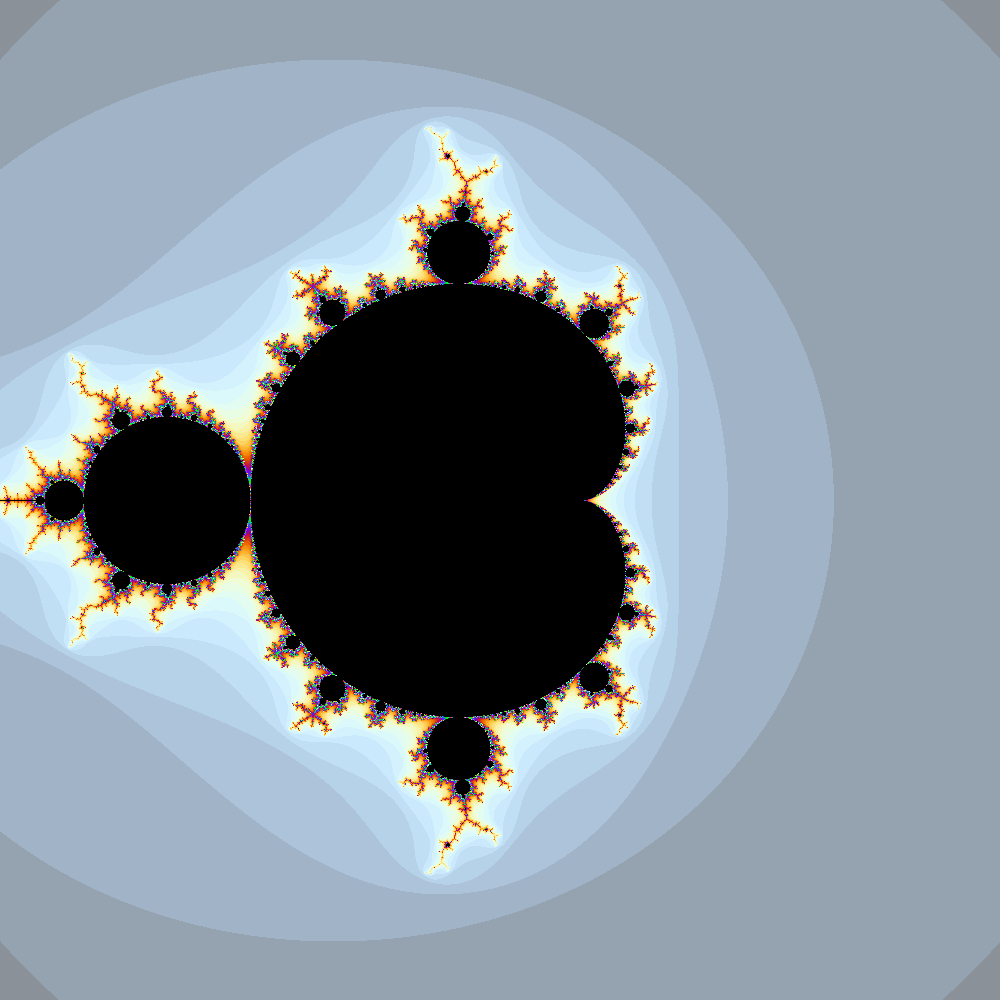

In [17]:
Image(dag_dir / "mandelbrot.png")